<h1>GAN - Generative Adversarial Network - from Scratch</h1>

Ein GAN ist ein Netzwerk, das aus zwei verschiedenen Komponenten besteht. Das Ziel ist es Bilder zu generieren.

Ein GAN besteht aus:<br>
- Einem Generator, der ein Bild erzeugen soll. Durch Anpassung der Weights kann das Model in eine Richtung gelenkt werden, das am Ende ein Vektor ausgibt das als Bild angezeigt werden kann. Quasi das Gegenteil von einem CNN.
- Ein Discriminator, der das Generatornetz evaluiert.

Beide können aus einem ANN oder CNN erstellt werden. Je umfangreicher das Netz ist, desto mehr Features kann es besser Abdecken.

Ein einfaches Netz kann aus zwei ANNs erstellt werden. 

GANs können in verschiedene Use-Cases eingesetzt werden. Um ein erstes einfaches Beispiel zu erstellen, ist die Aufgabe synthetische Bilder von einem Produkt herzustellen was für eine Qualitätskontrolle genutzt werden kann.

<i>Abb1</i>: [Coming soon]

<img>

Als Komponente haben wir ein 20 x 20 Bild mit einem "L" darauf. Das L könnte ein L-förmiges Bauteil sein. Bei der Produktion werden viele dieser Komponenten hergestellt.Mit der Synthetisierung dieser Bilder können wir mehr Daten generieren, die für das Training eines CNN verwendet werden können, um Abweichungen besser abzudecken. 

Wir gehen davon aus das es viel mehr Bilder von guten Bauteilen gibt und sehr wenige von nicht guten Bauteilen. Mit den synthetischen Bildern kann die Lücke geschlossen werden.

In [1]:
# Imports.
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image  as matimg
import cv2
import pandas as pd
from PIL import Image
from tensorflow.keras.preprocessing.text import one_hot

from sklearn.preprocessing import StandardScaler

<h2> Dataset </h2>

Um so ein Bild zu erstellen, kann ein Zeichenprogramm oder Numpy verwendet werden.

<i>Abb2</i>: Zeichnung L-Objekt.

<img src="./data/img/1_gan.PNG" width=400, height=400>

Alternativ kann auch mit Numpy eine einfache Form gezeichnet werden.

In [2]:
# Erstelle 1 Sample. 
def create_image(color:int=1) -> np.array:
    image = np.zeros((20, 20))  # 2D Matrix, 20x20 Pixel.
    # img [yloc, xloc]
    image[1:12, 7] = 1  # Zeichne Feld.
    image[1:12, 8] = 1  # Zeichne Feld.

    image[11, 9:15]  = 1  
    image[12, 7:15] = 1  

    return image

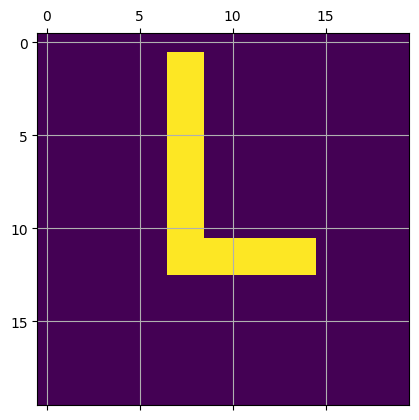

In [3]:
img = create_image()
plt.matshow(img)
plt.grid()

Schnell und einfach ist das Bild erstellt. 

<h3>Numpy Dataset</h3>

In [4]:
# Erstelle Dataset aus n-Samples 
def numpy_dataset(n:int):
    return np.array([create_image() for x in range(n)])
    
size = 950
dataset_numpy = numpy_dataset(size)
dataset_numpy.shape

(950, 20, 20)

In [5]:
dataset_numpy = dataset_numpy.reshape(size, 20, 20, 1).astype('float')

In [6]:
# Dann können die Daten normalisiert werden.
dataset_numpy_scaled = ( dataset_numpy - 0.5 ) / 0.5

Oder lade das Bild als numpy Array. 

In [7]:
# Lade Bild mit OpenCV.
# - Oder nutze Alternative wie PIL, ..., 
img = cv2.imread('./data/datasets/L__shape/lshape.jpg')
type(img)

numpy.ndarray

Danach kann das Bild in ein Dataframe geladen und ggf. Transformiert und angepasst werden. Oder nutze andere Methoden.

<h3>Tensorflow Dataset</h3>

In [250]:
# Lade Bild
img = tf.io.read_file('./data/datasets/L__shape/lshape.jpg')
img = tf.image.decode_jpeg(img)
img

<tf.Tensor: shape=(20, 20, 3), dtype=uint8, numpy=
array([[[248, 248, 248],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[246, 246, 246],
        [255, 255, 255],
        [253, 253, 253],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [247, 247, 247],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255]

In [253]:
# Erstelle Dataset
tf_dataset = tf.data.Dataset.from_tensors(img)
tf_dataset

<TensorDataset element_spec=TensorSpec(shape=(20, 20, 3), dtype=tf.uint8, name=None)>

Danach kann das TF-Dataset beliebig genutzt werden.

<h2>GAN Model - ANN</h2>

Dann erstellen wir zwei separate ANN Netze die verschiedene Aufgaben übernehmen.

In [157]:
# Generator ANN #

def create_generator():
    gen_ann = tf.keras.Sequential([
        # Input 100 Units, Output 128 Units.
        tf.keras.layers.Dense(units=128, input_shape=(100,), activation='relu'),
    
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(units=400, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(units=400, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        # Erstelle Vektor der dann als Bild 20x20 Pixel dargestellt wird.
        tf.keras.layers.Dense(units=20*20, activation='tanh'),
        tf.keras.layers.Reshape((20, 20, 1))
    ])
    return gen_ann


# Discriminator ANN # 
def create_discriminator():
    dis_ann = tf.keras.Sequential([
        # Bild als Input. Netz soll Fake-Images erkennen. 
        tf.keras.layers.Flatten(input_shape=(20,20, 1)),
        tf.keras.layers.Dense(350, activation='relu'),
        tf.keras.layers.Dense(450, activation='relu'),
        tf.keras.layers.Dense(200, activation='relu'),
        # Als Output: Fake oder nicht.
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    return dis_ann

discriminator = create_discriminator()
discriminator.compile(
    optimizer = 'adam',
    loss      = 'binary_crossentropy',
    metrics   = 'accuracy'
)

Für einfache Formen sind die Netze ausreichend. Diese können später weiter optimiert werden.

Der nächste wichtige Schritt ist das Netz zu trainieren. Dazu fügen wir beide Netze zusammen und trainieren vorerst nur den Generator. 
- Mit einem Parameter können die Weights eines Models eingefroren werden. 

In [158]:
discriminator.trainable = False

In [159]:
# Erstelle GAN
generator = create_generator()
gan_input = tf.keras.layers.Input(shape=(100,))  # 100 Startpixel.
gen_image = generator(gan_input)

net_output = discriminator(gen_image)
GAN        = tf.keras.Model(gan_input, net_output)

GAN.compile(optimizer='adam', loss='binary_crossentropy')

Anders als sonst in Tensorflow schreiben wir eine detailreiche Trainingsschleife. 
- Batching möglich.

Später werden wir uns weitere Details anschauen.

In [56]:
# Für das Batching: # 
# - Random-Index mit:
np.random.randint(0, 3, 3)  #  (low, high, size)

array([0, 2, 0])

In [57]:
# Generator Input # 
# - Üblich: Rauschen. Kann aber alles sein... 
#   => Aus dem Rauschen soll ein Bild entstehen. 
np.random.normal(0, 1, (2, 100))  # (loc, scale, size(x-Samples, shape))

array([[-8.39782962e-01, -3.10202128e-01,  1.65800969e+00,
        -4.97675987e-01,  7.78550346e-01,  9.68748206e-01,
        -3.04415937e-01, -1.89076281e-02, -3.73261651e-01,
        -1.55525828e+00,  4.70532909e-01, -2.68442098e-01,
        -1.15237504e+00, -9.63809818e-01, -1.48104211e-01,
        -6.57777960e-02,  2.70712605e-02,  1.17791695e+00,
         5.52461789e-01,  1.40414667e+00, -1.60979634e+00,
         5.92170840e-01,  7.01905012e-01,  3.40010321e-01,
        -6.62022982e-01,  1.40517590e+00, -7.16884546e-01,
         1.49486669e+00, -1.70991389e-01,  5.32584580e-01,
        -1.19370327e+00, -1.58983268e-01, -4.51101165e-01,
        -4.53239770e-01,  1.61885635e-01, -1.50889754e+00,
         3.99815155e-01,  1.85668892e+00, -2.36656145e-03,
        -1.49685538e+00,  2.73424970e+00,  1.58790819e+00,
        -9.51698690e-01, -1.02370542e+00, -6.01330298e-01,
         3.47095996e-01,  1.06514052e+00, -1.82129192e+00,
        -1.62315857e+00, -1.10836805e+00,  3.65105948e-0

In [58]:
np.ones(5)

array([1., 1., 1., 1., 1.])

In [160]:
# Trainingsschleife # 

def train(generator, discriminator, gan, train_img, epochs, batch_size):
    
    half_batch = int(batch_size / 2)  # Ausgleich an Samples für beide Netze. 
    
    for epoch in range(epochs):  # Für jede Epoche mach das:
        # Discriminator # 
        index = np.random.randint(0, train_img.shape[0], half_batch)  # Index für Samples. 
        real_images = train_img[index]  # Hole Samples.
        noise       = np.random.normal(0, 1, (half_batch, 100))  # Erstelle Rauschen als Input. Kann aber auch komplett 0 sein. Üblich: Rauschen.
        fake_images = generator.predict(noise)  # Erstelle Prediction. 

        # Berechne Loss. # Setze Labels.
        # - train_on_batch(x, y), beide müssen n-Samples haben. 
        loss_real = discriminator.train_on_batch(real_images, np.ones(  (half_batch, 1) ))  # Label 1 für n-Samples für echte Bilder. 
        loss_fake = discriminator.train_on_batch(fake_images, np.zeros( (half_batch, 1) ))  # Label 0 für n-Samples für UN-echte Bilder.
        d_loss = 0.5 * np.add(loss_real, loss_fake)  # Schnitt der Beiden Losses. 

        # Generator # Wie Oben. 
        noise    = np.random.normal(0, 1, (batch_size, 100))
        y        = np.ones(batch_size)
        gan_loss = gan.train_on_batch(noise, y)

        # Manuelle Ausgabe.:
        print(f"Epoche: {epoch + 1}/{epochs} GAN loss: {gan_loss}")

In [161]:
train(generator, discriminator, GAN, dataset_numpy_scaled, epochs=700, batch_size=64)

1/1 [==============================] - 0s 81ms/step
Epoche: 1/700 GAN loss: 0.6848864555358887
1/1 [==============================] - 0s 14ms/step
Epoche: 2/700 GAN loss: 0.9235652685165405
1/1 [==============================] - 0s 14ms/step
Epoche: 3/700 GAN loss: 1.4462690353393555
1/1 [==============================] - 0s 15ms/step
Epoche: 4/700 GAN loss: 2.27596116065979
1/1 [==============================] - 0s 14ms/step
Epoche: 5/700 GAN loss: 3.2589735984802246
1/1 [==============================] - 0s 14ms/step
Epoche: 6/700 GAN loss: 4.243983268737793
1/1 [==============================] - 0s 14ms/step
Epoche: 7/700 GAN loss: 5.2005934715271
1/1 [==============================] - 0s 14ms/step
Epoche: 8/700 GAN loss: 6.154271602630615
1/1 [==============================] - 0s 13ms/step
Epoche: 9/700 GAN loss: 6.726434707641602
1/1 [==============================] - 0s 13ms/step
Epoche: 10/700 GAN loss: 7.356412887573242
1/1 [==============================] - 0s 14ms/step
Epoche

<h2>Erzeuge Bilder</h2>

So, das Training ist beendet, wie können wir aber jetzt Bilder erzeugen? <br>
Dazu geben wir dem Generator ein Startbild als Vektor, daraus soll dann Schritt für Schritt das Bild erzeugt werden. Später muss der Vektor durch das Netz oder Manuell in  die richtige Form gebracht werden.
- Die Skalierung des Bildes sollte vor dem Plotten umgekehrt werden.

In [162]:
# Erzeuge Bild und gebe als array zurück.
def generate_img(noise, generator) -> np.array:
    image = generator.predict(noise)  # Gebe Startbild => Netz => Prediction 
    image = 0.5 * image + 0.5  # Kehre die Skalierung um. 
    image = image.reshape((20,20,1))
    return image

# Plote Bild. 
def plot_image(img:np.array, gray=False):
    plt.figure(figsize=(3,3))
    if gray:
        plt.imshow(img,  cmap='gray')
    else:
         plt.imshow(img)
    plt.xlabel('X-Pixel')
    plt.ylabel("Y-Pixel")
    plt.title("Image")

In [163]:
# Startbild.
start_img = np.random.normal(0, 1, (1, 100)).reshape((10,10, 1))

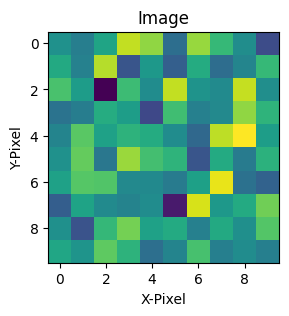

In [164]:
# Oder als schwarz/weiß.
plot_image(start_img)

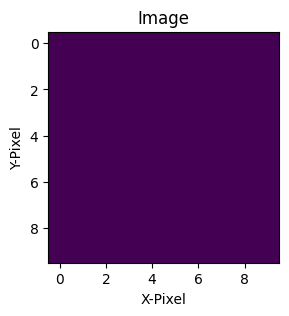

In [165]:
start_img_2 = np.random.normal(0, 0, (1, 100)).reshape((10,10, 1))
plot_image(start_img_2)

1/1 [==============================] - 0s 14ms/step


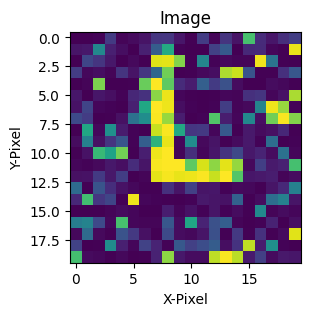

In [166]:
start_img = np.random.normal(0, 1, (1, 100))
img = generate_img(start_img, gen_ann)
plot_image(img, gray=False)

Was passiert wenn immer der gleiche Input gegeben wird? 
- Die Prediction-Funktion (Netz und Parameter) liefert immer dasselbe Ergebnis => Koeffizienten sind statisch genau wie Bias, daher kommt immer das gleiche heraus. 

1/1 [==============================] - 0s 14ms/step


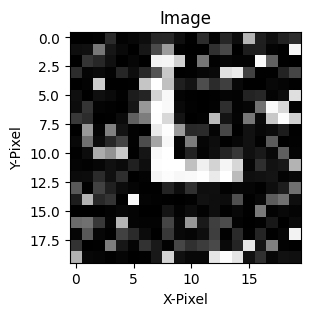

In [167]:
# Nehme selben Input.
img = generate_img(start_img, gen_ann)
plot_image(img, gray=True)

In [168]:
y_true = generate_img(start_img, gen_ann).reshape((400,))

y_pred = [generate_img(start_img, gen_ann).reshape((400,)) for _ in range(5)]

1/1 [==============================] - 0s 14ms/step


In [169]:
for idx in range(len(y_pred)):
    print(np.array_equal(y_true, y_pred[idx]))

True
True
True
True
True


Durch den Einbau von Seeds Dropouts und weitere Elementen kann eine Dynamik miteingebracht werden, damit jedes nachfolgende Bild sich von den vorherigen unterscheidet. 
- `np.random.normal` erzeugt immer einen anderen Input für das Model.

<h2>Speichere Bilder während des Trainings</h2>

Während des Trainings können die Bilder nach n-Epochen gespeichert werden, um die Entwicklung sichtbar zu machen. <br>
Auch Möglich: <br>
- Vergleiche Vektoren: wie ähnlich sind diese am Ende?
- Extrahiere Vektor jedes Layers des Models: Entwicklungsschritte Layer für Layer (möglich, wenn daraus ein Bild konstruiert werden kann).

In [198]:
def save_img(img, epoch):
    img = 0.5 * img + 0.5
    matimg.imsave(f'./data/data/1__GAN/img{epoch}.jpeg', img.reshape((20,20)))

def train(generator, discriminator, gan, train_img, epochs, batch_size): 
    half_batch = int(batch_size / 2)  
    for epoch in range(epochs):  
        index = np.random.randint(0, train_img.shape[0], half_batch)  
        real_images = train_img[index]  # Hole Samples.
        noise       = np.random.normal(0, 1, (half_batch, 100)) 
        fake_images = generator.predict(noise)  # Erstelle Prediction. 
        # Berechne Loss. # Setze Labels.
        loss_real = discriminator.train_on_batch(real_images, np.ones(  (half_batch, 1) ))  # Label 1 für n-Samples für echte Bilder. 
        loss_fake = discriminator.train_on_batch(fake_images, np.zeros( (half_batch, 1) ))  # Label 0 für n-Samples für UN-echte Bilder.
        d_loss = 0.5 * np.add(loss_real, loss_fake)  # Schnitt der Beiden Losses. 
        # Generator # Wie Oben. 
        noise    = np.random.normal(0, 1, (batch_size, 100))
        y        = np.ones(batch_size)
        gan_loss = gan.train_on_batch(noise, y)
        # Manuelle Ausgabe.:
        print(f"Epoche: {epoch + 1}/{epochs} GAN loss: {gan_loss}")

        if (epoch%200==0) | (epoch+1==epochs):
            save_img(fake_images[0], epoch)
            

In [199]:
discriminator = create_discriminator()
discriminator.compile(
    optimizer = 'adam',
    loss      = 'binary_crossentropy',
    metrics   = 'accuracy'
)
discriminator.trainable = False
# Erstelle GAN
generator = create_generator()
gan_input = tf.keras.layers.Input(shape=(100,))  # 100 Startpixel.
gen_image = generator(gan_input)
net_output = discriminator(gen_image)
GAN        = tf.keras.Model(gan_input, net_output)
GAN.compile(optimizer='adam', loss='binary_crossentropy')

In [200]:
train(generator, discriminator, GAN, dataset_numpy_scaled, epochs=1200, batch_size=64)

1/1 [==============================] - 0s 81ms/step
Epoche: 1/1200 GAN loss: 0.6330462694168091
1/1 [==============================] - 0s 14ms/step
Epoche: 2/1200 GAN loss: 0.9008914232254028
1/1 [==============================] - 0s 14ms/step
Epoche: 3/1200 GAN loss: 1.4039802551269531
1/1 [==============================] - 0s 14ms/step
Epoche: 4/1200 GAN loss: 2.2934913635253906
1/1 [==============================] - 0s 14ms/step
Epoche: 5/1200 GAN loss: 3.459859848022461
1/1 [==============================] - 0s 14ms/step
Epoche: 6/1200 GAN loss: 4.912616729736328
1/1 [==============================] - 0s 14ms/step
Epoche: 7/1200 GAN loss: 6.107210636138916
1/1 [==============================] - 0s 15ms/step
Epoche: 8/1200 GAN loss: 7.121273994445801
1/1 [==============================] - 0s 15ms/step
Epoche: 9/1200 GAN loss: 7.913349151611328
1/1 [==============================] - 0s 14ms/step
Epoche: 10/1200 GAN loss: 8.714920043945312
1/1 [==============================] - 0s 14m

In [207]:
import os
path ='./data/data/1__GAN/'
os.listdir(path)

['img0.jpeg',
 'img1000.jpeg',
 'img1199.jpeg',
 'img200.jpeg',
 'img400.jpeg',
 'img600.jpeg',
 'img800.jpeg']

In [211]:
images = [np.asarray(Image.open(path+imgname)) for imgname in os.listdir(path)]
len(images)

7

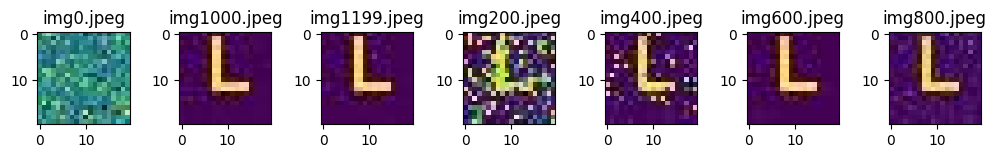

In [226]:
# Füge optional weitere Inhalte zu.
fig, axs = plt.subplots(1, 7, figsize=(10, 6))
fig.tight_layout(pad=0.5)
axs = axs.ravel()

img_names = os.listdir(path)


for i in range(len(images)):
    axs[i].set_title(img_names[i])
    axs[i].imshow(images[i])

<h1>Zweites Beispiel - 2 Verschiedene Formen</h1>

Diesmal wollen wir 2 Formen und ein größeres Netz nutzen. Das Vorgehen ist ähnlich aber Umfangreicher.

Um ein GAN zu erstellen, das verschiedene Klassen unterscheidet, nutzen wir Embeddings, um den Input des Generators zu verändern.<br>
Zusätzlich können wir Dropouts nutzen. Bei komplexeren Formen und größeren Netzen nutzen wir auch CNN Layers. Weitere ist optional.
- Hier wieder als ANN. CNN ist üblich bei GANs.
- Es ist üblich, das man für das Training mehrere Klassen nutzt.

<h2>Dataset</h2>

Für den Versuch erstellen wir 2 Formen- einmal mit einem Zeichenprogramm und einmal mit Numpy.

In [8]:
# Zeichne Bild mit Numpy.
def create_image_2(color:int=1) -> np.array:
    image = np.zeros((20, 20))  # 2D Matrix, 20x20 Pixel.
    # img [yloc, xloc]
    image[1:17, 3]  = 1  
    image[1:17, 4]  = 1  
    image[2:10, 10] = 1  
    image[2:10, 11] = 1  
    image[9, 4:10]  = 1  
    image[10, 4:12] = 1 
    image[1, 4:17]  = 1  
    image[2, 4:17]  = 1 
    return image

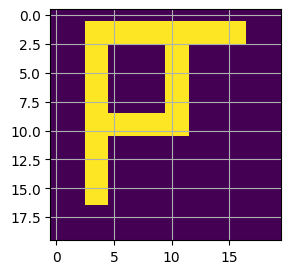

In [9]:
img = create_image_2()
plt.figure(figsize=(3,3))
plt.imshow(img)
plt.grid()

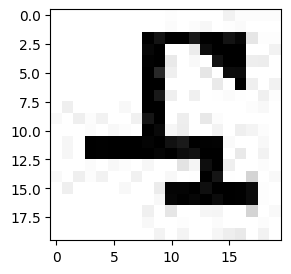

In [10]:
plt.figure(figsize=(3,3))
img = np.asarray(Image.open('./data/datasets/two_shapes/shape.jpg'))
plt.imshow(img)

Dann erstellen wir ein Encoding für die Labels als Input für das Embedding. 

In [11]:
# Erstelle Labels für Embeddings:
# - Mit 0 und 1 soll die Klasse "ausgewählt" werden.
form_labels    = ['Form A', 'Form B']
encoded_labels = {'Form A':0, 'Form B': 1}

In [12]:
# Erstelle Dataset aus n-Samples 
def numpy_dataset(n:int):  # Shape A, Label 0
    return np.array([create_image_2() for _ in range(n)])

def load_img_array(n:int):  # Shape B, Label 1
    return np.array([np.array(Image.open('./data/datasets/two_shapes/shape.jpg').convert('L')) for _ in range(n)])

In [35]:
size = 1000  # n-Samples

dataset_shape_A = numpy_dataset(  size)
#dataset_shape_B = load_img_array( size)
dataset_shape_B = np.array([create_image() for _ in range(size)])  # Shape L 

print(dataset_shape_A.shape, dataset_shape_B.shape )

(1000, 20, 20) (1000, 20, 20)


In [36]:
# Reshape. # 
dataset_shape_A = dataset_shape_A.reshape(size, 20, 20, 1).astype('float')
dataset_shape_B = dataset_shape_B.reshape(size, 20, 20, 1).astype('float')

In [37]:
# Skaliere. #
dataset_shape_A = ( dataset_shape_A - 0.5 ) / 0.5
dataset_shape_B = ( dataset_shape_B - 0.5 ) / 0.5

In [38]:
dataset_shape_A[0].shape

(20, 20, 1)

In [39]:
dataset_shape_B[0].shape

(20, 20, 1)

In [40]:
# Erstelle Dataset mit A und B. 
dataset_shapes = []
dataset_shapes.extend(dataset_shape_A)  # Label 0
dataset_shapes.extend(dataset_shape_B)  # Label 1
dataset_shapes = np.array(dataset_shapes)

In [41]:
# Erstelle Dataset Labels # 
dataset_labels = np.asarray([encoded_labels[label]   for label in form_labels  for _ in range(size)])

In [42]:
len(dataset_labels) == size*2

True

Das ist eine Möglichkeit Datasets zu erstellen.

<h2>Erstelle Model</h2>

Diesmal hat das Model Embeddings, um mehrere Klassen abzudecken.

In [43]:
# Erstelle Generator für Bildgenerierung # 
def create_generator(num_classes: int = 2):
    # Hier Nutzen wir zusätzlich Embeddings Layers.

    noise_input = tf.keras.Input(shape=(100,))  # Startbild: 100 Pixel Vektor. 
    label_input = tf.keras.Input(shape=(1,), dtype='int32') # Klassen Label wie z. B. Form_A, Form_B als 0 und 1. 
    
    label_embedding = tf.keras.layers.Embedding(input_dim=2, output_dim=100)(label_input)
    label_embedding = tf.keras.layers.Flatten()(label_embedding)
    model_input     = tf.keras.layers.multiply([noise_input, label_embedding])  # Multipliziere, damit haben die Labels direkten Einfluss.
    
    # --------- #
    """ 
    gen_ann = tf.keras.Sequential()
    gen_ann.add( tf.keras.layers.Dense(units=300, activation='relu'))
    gen_ann.add( tf.keras.layers.BatchNormalization())
    gen_ann.add( tf.keras.layers.Dense(units=500, activation='relu'))

    """
    # Nutze andere Herangehensweise. 
    # - Dieser Ansatz funktioniert besser. 
    x = tf.keras.layers.Dense(units=300, activation='relu')(model_input)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dense(units=500, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dense(units=800, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.1)(x)
    x = tf.keras.layers.Dense(units=450, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dense(units=20*20, activation='tanh')(x)
    output = tf.keras.layers.Reshape((20, 20, 1))(x)
   
    return tf.keras.Model([noise_input, label_input], output)

In [44]:
# Teste, ob Aufbau funktioniert. 
generator = create_generator(2)
noise     = np.random.normal(0, 1, (1, 100))

fake_labels = np.random.randint(0, 2, 1)
fake_images = generator.predict([noise, fake_labels])

1/1 [==============================] - 0s 102ms/step


In [45]:
def create_discriminator(num_classes: int = 2):
    # Hier Nutzen wir zusätzlich Embeddings.
    
    image_input = tf.keras.Input(shape=(20, 20, 1))  # Bild als Input
    label_input = tf.keras.Input(shape=(1,), dtype='int32')  # Auch hier kommen die Labels zum Einsatz. 
    
    label_embedding = tf.keras.layers.Embedding(input_dim=2, output_dim=20*20)(label_input)
    label_embedding = tf.keras.layers.Flatten()(label_embedding)
    label_embedding = tf.keras.layers.Reshape((20, 20, 1))(label_embedding) 
    # Durch Konkatenation: Passt Bild auch zum Label? 
    model_input = tf.keras.layers.concatenate([image_input, label_embedding])   
    # --------- #
    x = tf.keras.layers.Flatten(input_shape=(20,20, 1))(model_input)
    x = tf.keras.layers.Dense(500, activation='relu')(x)
    x = tf.keras.layers.Dense(700, activation='relu')(x)
    x = tf.keras.layers.Dense(550, activation='relu')(x)
    x = tf.keras.layers.Dense(320, activation='relu')(x)
    x = tf.keras.layers.Dense(150, activation='relu')(x)
    x = tf.keras.layers.Dense(75, activation='relu')(x)
    output =  tf.keras.layers.Dense(1, activation='sigmoid')(x)
   
    return tf.keras.Model([image_input, label_input], output)

In [18]:
# Teste, ob Aufbau funktioniert. 
discriminator = create_discriminator()

generator = create_generator(2)
noise     = np.random.normal(0, 1, (1, 100))

fake_labels = np.random.randint(0, 2, 1)
fake_images = generator.predict([noise, fake_labels])

discriminator.predict([fake_images, fake_labels])

1/1 [==============================] - 0s 72ms/step


array([[0.5010406]], dtype=float32)

In [46]:
discriminator = create_discriminator()
discriminator.compile(
    optimizer = 'adam',
    loss      = 'binary_crossentropy',
    metrics   = 'accuracy'
)
discriminator.trainable = False

# Erstelle GAN # 
generator = create_generator()
gan_input   = tf.keras.layers.Input(shape=(100,))  
label_input = tf.keras.Input(shape=(1,), dtype='int32')

generated_image = generator([gan_input, label_input])
gan_output = discriminator([generated_image, label_input])

GAN = tf.keras.Model([gan_input, label_input], gan_output)
GAN.compile(loss='binary_crossentropy', optimizer='adam')

GAN.compile(optimizer='adam', loss='binary_crossentropy')

<h2>Training</h2>

In [47]:
# Trainingsschleife #
# - Sehr ähnlicher Aufbau mit kleinen Unterschieden. 
def train(generator, discriminator, gan, train_images, train_labels, epochs, batch_size, num_classes:int=2):
    
    half_batch = int(batch_size / 2)  # Ausgleich an Samples. 
    
    for epoch in range(epochs):
        #  Discriminator #
        idx = np.random.randint(0, train_images.shape[0], half_batch)  # Index für Img und Label. 
        real_images = train_images[idx]  # Wie bisher.
        real_labels = train_labels[idx]  # Nehme Labels dazu. 
        noise       = np.random.normal(0, 1, (half_batch, 100))  # Startbild.
        fake_labels = np.random.randint(0, num_classes, half_batch)  # Wie Bisher.
        fake_images = generator.predict([noise, fake_labels])  # Nehme Labels dazu. 

        loss_real = discriminator.train_on_batch([real_images, real_labels], np.ones(  (half_batch, 1)))  # Wie bisher
        loss_fake = discriminator.train_on_batch([fake_images, fake_labels], np.zeros( (half_batch, 1)))  # Wie bisher.
        d_loss = 0.5 * np.add(loss_real, loss_fake)  # Wie bisher.

        # Generator #
        noise = np.random.normal(0, 1, (batch_size, 100))  # Startbild
        labels= np.random.randint(0, num_classes, batch_size)  # Labels
        y = np.ones((batch_size, 1))
        g_loss = gan.train_on_batch([noise, labels], y)

        # Manuelle Ausgabe.:
        print(f"Epoche: {epoch + 1}/{epochs} GAN loss: {g_loss}")


In [48]:
# Train the GAN
train(generator, discriminator, GAN, dataset_shapes, dataset_labels, epochs=1400, batch_size=16)

1/1 [==============================] - 0s 102ms/step
Epoche: 1/1400 GAN loss: 0.5761806964874268
1/1 [==============================] - 0s 15ms/step
Epoche: 2/1400 GAN loss: 0.3762649595737457
1/1 [==============================] - 0s 16ms/step
Epoche: 3/1400 GAN loss: 0.23936408758163452
1/1 [==============================] - 0s 15ms/step
Epoche: 4/1400 GAN loss: 0.19176720082759857
1/1 [==============================] - 0s 26ms/step
Epoche: 5/1400 GAN loss: 0.1752128005027771
1/1 [==============================] - 0s 16ms/step
Epoche: 6/1400 GAN loss: 0.23676997423171997
1/1 [==============================] - 0s 16ms/step
Epoche: 7/1400 GAN loss: 0.2515065670013428
1/1 [==============================] - 0s 16ms/step
Epoche: 8/1400 GAN loss: 0.4967023730278015
1/1 [==============================] - 0s 15ms/step
Epoche: 9/1400 GAN loss: 1.100185751914978
1/1 [==============================] - 0s 15ms/step
Epoche: 10/1400 GAN loss: 2.6646571159362793
1/1 [==============================]

<h2>Predict mit 2 Klassen</h2>

Jetzt können wir durch eingab eines Labels die Generierung der Bilder verändern.

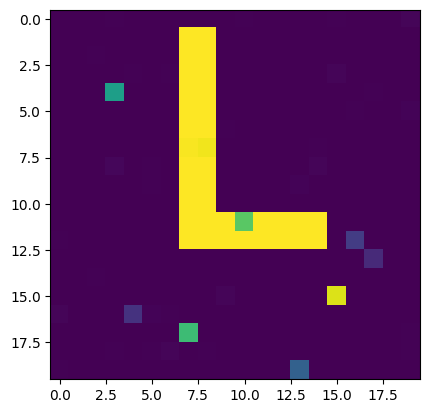

In [51]:
noise = np.random.normal(0, 1, (1, 100)) 
img   = generator([noise, np.array([1])])
plt.imshow(img[0])

<h1>Sonstiges</h1>